In [257]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# Load Data

In [258]:
import os, re
import pandas as pd

def load_raw_data(root_dir, sensors=("Accelerometer", "Gravity", "Gyroscope")):
    """
    Load raw sensor data into a nested dictionary.

    Structure:
        data[activity][trial][student][sensor] = DataFrame

    Folder naming convention:
        "{Activity}_{trial}_{student}"
        e.g. "Sit_1_Student1"

    Parameters
    ----------
    root_dir : str
        Root directory containing activity folders.
    sensors : tuple of str
        Sensor names to load (case-sensitive, must match CSV filenames).

    Returns
    -------
    dict
        Nested dictionary with DataFrames.
    """

    data = {}

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Match folder name pattern
        match = re.match(r"([A-Za-z]+)_(\d+)_([A-Za-z0-9]+)", folder)
        if not match:
            print(f"[load_raw_data] Skipping {folder} (unexpected name format)")
            continue

        activity, trial, student = match.groups()

        # Initialize nested dicts
        data.setdefault(activity, {}).setdefault(trial, {}).setdefault(student, {})

        # Load each sensor file if it exists
        for sensor in sensors:
            file_path = os.path.join(folder_path, f"{sensor}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                data[activity][trial][student][sensor.lower()] = df
            else:
                print(f"[load_raw_data] Missing {file_path}")

    return data


In [259]:
data = load_raw_data("Raw Data")

In [260]:
data["Stand"]["1"]["Student1"]["accelerometer"]   

,time,seconds_elapsed,z,y,x
0,1759157627659409400,0.019409,0.012783,0.107280,-0.044314
1,1759157627669467400,0.029467,0.029959,0.081197,-0.053373
2,1759157627679524400,0.039524,0.003599,0.138549,-0.037378
3,1759157627689581800,0.049582,-0.013361,0.171658,-0.031640
4,1759157627699639800,0.059640,0.013671,0.143785,-0.015338
...,...,...,...,...,...
533,1759157633020415700,5.380416,-0.206405,0.141028,-0.276440
534,1759157633030474000,5.390474,-0.187276,-0.070544,-0.314168
535,1759157633040532700,5.400533,-0.111666,-0.108651,-0.326882
536,1759157633050590700,5.410591,-0.048610,-0.034493,-0.259095


# 1) Data Preprocessing Pipeline

1) Combine sensor data together

2) Trimming

3) Windowing 

4) Saving

In [261]:
import pandas as pd

SENSOR_PREFIX_MAP = {
    "accelerometer": "acc",
    "gyroscope": "gyro",
    "gravity": "grav",
}

def _sensor_prefix(sensor_key: str) -> str:
    s = sensor_key.lower()
    for k, v in SENSOR_PREFIX_MAP.items():
        if s.startswith(k[:3]):  # acc, gyr, gra
            return v
    return s

def combine_sensors_first(
    data,
    time_col_candidates=("seconds_elapsed", "time"),
    require_equal_length=True,
    keep_time=True
):
    """
    Convert:
        data[activity][trial][student][sensor] = DataFrame
    into:
        combined[activity][trial][student] = DataFrame  (columns: time?, acc_*, gyro_*, grav_*)

    Assumes sensors share the same timestamps/order. If `require_equal_length` is True,
    mismatched lengths raise an AssertionError.
    """
    def _time_cols(df):
        return [c for c in time_col_candidates if c in df.columns]

    combined = {}
    for activity, trials in data.items():
        combined[activity] = {}
        for trial, students in trials.items():
            combined[activity][trial] = {}
            for student, sensors in students.items():
                # Collect available sensor DFs
                sensor_items = [(s, df) for s, df in sensors.items() if isinstance(df, pd.DataFrame) and not df.empty]
                if not sensor_items:
                    combined[activity][trial][student] = pd.DataFrame()
                    continue

                # Optionally check equal lengths
                lens = {s: len(df) for s, df in sensor_items}
                if require_equal_length and len(set(lens.values())) != 1:
                    raise AssertionError(f"Different lengths at {activity}/{trial}/{student}: {lens}")

                # Build parts: one time column + prefixed feature cols
                parts = []
                time_added = False
                for s, df in sorted(sensor_items, key=lambda x: x[0]):  # stable order
                    tcols = _time_cols(df)
                    # Add time once
                    if keep_time and not time_added and tcols:
                        parts.append(df[tcols[0]].reset_index(drop=True))
                        time_added = True
                    # Add features with sensor prefix
                    non_time = [c for c in df.columns if c not in set(tcols)]
                    if non_time:
                        pref = _sensor_prefix(s)
                        renamed = {c: f"{pref}_{c.lower()}" for c in non_time}
                        parts.append(df[non_time].rename(columns=renamed).reset_index(drop=True))

                combined_df = pd.concat(parts, axis=1) if parts else pd.DataFrame()
                combined[activity][trial][student] = combined_df

    return combined


In [262]:
# To drop time columns after windowing
TIME_COL_CANDS = ["seconds_elapsed", "time"]

def _get_time_col(df):
    """
    Return the first matching time column from TIME_COL_CANDS.
    Assumes at least one of them is present.
    """
    for col in TIME_COL_CANDS:
        if col in df.columns:
            return col
    raise ValueError("No valid time column found. Expected one of: " + ", ".join(TIME_COL_CANDS))


def _crop_segment(df, start_offset_s, duration_s, time_col, hz=100.0):
    """
    For activities like Sit/Stand:
    Take a fixed segment starting at row index corresponding to start_offset_s * hz
    and keep exactly duration_s * hz samples (index-based, like window_all_100hz).

    Parameters
    ----------
    df : pd.DataFrame
    start_offset_s : float
        Offset in seconds from the *first row* of df.
    duration_s : float
        Desired window length in seconds.
    time_col : str
        Unused for filtering here (kept for API consistency).
    hz : float
        Assumed sampling rate (default 100.0 Hz).

    Returns
    -------
    pd.DataFrame
        Cropped DataFrame with reset index; empty if not enough rows.
    """
    if df is None or df.empty:
        return df

    n_off = int(round(float(start_offset_s) * float(hz)))
    n_win = int(round(float(duration_s) * float(hz)))
    if n_off < 0 or n_win <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    start_idx = n_off
    end_idx = start_idx + n_win

    if start_idx >= len(df) or end_idx <= 0:
        return df.iloc[0:0].reset_index(drop=True)

    # Clamp to available range
    start_idx = max(0, start_idx)
    end_idx = min(len(df), end_idx)

    # If the clamped slice is shorter than requested window, return empty (strict)
    if end_idx - start_idx < n_win:
        return df.iloc[0:0].reset_index(drop=True)

    return df.iloc[start_idx:end_idx].reset_index(drop=True)


def _crop_trim(df, start_trim_s, end_trim_s, time_col):
    """
    For other activities:
    Trim 'start_trim_s' seconds from the beginning,
    and 'end_trim_s' seconds from the end of the recording.
    """
    t_min, t_max = float(df[time_col].min()), float(df[time_col].max())
    start_bound = t_min + float(start_trim_s)
    end_bound   = t_max - float(end_trim_s)
    # Guard: if trims remove the whole range, return empty DataFrame
    if start_bound >= end_bound:
        return df.iloc[0:0].reset_index(drop=True)
    return df[(df[time_col] >= start_bound) & (df[time_col] <= end_bound)].reset_index(drop=True)

def crop_mixed_combined(
    data_combined,
    sit_stand_start_offset_s=1.5,
    window_size_s=2.0,
    trims_start=None,
    trims_end=None,
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
    verbose=False
):
    """
    Input:
        data_combined[activity][trial][student] = DataFrame (time + all sensor cols)
    Output:
        cropped[activity][trial][student] = DataFrame (cropped)
    """
    if trims_start is None: trims_start = 2.0
    if trims_end   is None: trims_end   = 2.0

    def _resolve(activity, val):
        return val.get(activity, val.get(activity.capitalize(), 0)) if isinstance(val, dict) else val

    cropped = {}
    for activity, trials in data_combined.items():
        cropped[activity] = {}
        for trial, students in trials.items():
            cropped[activity][trial] = {}
            for student, df in students.items():
                if not isinstance(df, pd.DataFrame) or df.empty:
                    cropped[activity][trial][student] = df
                    if verbose:
                        print(f"[crop_mixed_combined] Empty: {activity}-{trial}-{student}")
                    continue

                # detect time col if present
                try:
                    tcol = _get_time_col(df)
                except ValueError:
                    tcol = None  # allow time-less data if you already index by samples

                if activity in sit_stand_set:
                    # fixed-length segment by sample count (uses hz)
                    if tcol is None:
                        # no time column needed for count-based crop
                        out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, time_col="", hz=hz)
                    else:
                        out = _crop_segment(df, sit_stand_start_offset_s, window_size_s, tcol, hz=hz)
                else:
                    if tcol is None:
                        # fall back: trim by samples if no time
                        n0 = int(round(_resolve(activity, trims_start) * hz))
                        n1 = int(round(_resolve(activity, trims_end) * hz))
                        if n0 + n1 >= len(df):
                            out = df.iloc[0:0].reset_index(drop=True)
                        else:
                            out = df.iloc[n0:len(df)-n1].reset_index(drop=True)
                    else:
                        # trim by time bounds
                        s_trim = _resolve(activity, trims_start)
                        e_trim = _resolve(activity, trims_end)
                        out = _crop_trim(df, s_trim, e_trim, tcol)

                cropped[activity][trial][student] = out

    return cropped


In [263]:
def window_all_100hz_combined(
    data_combined,
    window_size_s=2.0,
    step_s=None,
    keep_time_col=True,  # keep time since you combined early
    time_col_candidates=("seconds_elapsed", "time")
):
    """
    Input:
        data_combined[activity][trial][student] = DataFrame
    Output:
        windows[activity][trial][student] = [DataFrame, ...]
    """
    HZ = 100.0
    if step_s is None:
        step_s = window_size_s

    n_win = int(round(window_size_s * HZ))
    n_stp = int(round(step_s * HZ))
    if n_win <= 0 or n_stp <= 0:
        raise ValueError("window_size_s and step_s must be > 0.")

    def _drop_time(df):
        drops = [c for c in time_col_candidates if c in df.columns]
        return df.drop(columns=drops) if (not keep_time_col and drops) else df

    def _make_windows(df):
        if df is None or df.empty: return []
        N = len(df)
        last_start = N - n_win
        if last_start < 0: return []
        out = []
        for s in range(0, last_start + 1, n_stp):
            e = s + n_win
            out.append(_drop_time(df.iloc[s:e].copy()).reset_index(drop=True))
        return out

    windows = {}
    for activity, trials in data_combined.items():
        windows[activity] = {}
        for trial, students in trials.items():
            windows[activity][trial] = {}
            for student, df in students.items():
                windows[activity][trial][student] = _make_windows(df)
    return windows


In [264]:
def save_windows_simple(
    windows,
    out_dir="windows_out"
):
    """
    Input:
        windows[activity][trial][student] = [DataFrame_win0, ...]
    """
    os.makedirs(out_dir, exist_ok=True)
    index_rows = []

    for activity, trials in windows.items():
        for trial, students in trials.items():
            for student, win_list in students.items():
                for i, wdf in enumerate(win_list):
                    rel = f"{activity}/trial_{trial}/{student}/win_{i}.csv"
                    path = os.path.join(out_dir, rel)
                    os.makedirs(os.path.dirname(path), exist_ok=True)
                    wdf.to_csv(path, index=False)
                    index_rows.append({
                        "activity": activity,
                        "trial": trial,
                        "student": student,
                        "window_idx": i,
                        "path": path
                    })

    idx = pd.DataFrame(index_rows)
    idx.to_csv(os.path.join(out_dir, "index.csv"), index=False)
    return idx


In [268]:
# 1) Combine sensors first
combined = combine_sensors_first(
    data,
    time_col_candidates=("seconds_elapsed", "time"),
    require_equal_length=True,
    keep_time=True
)

# 2) Crop differently by activity on the combined DF
cropped = crop_mixed_combined(
    combined,
    sit_stand_start_offset_s=1.0,
    window_size_s=2.0,
    trims_start={"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0},
    trims_end={"Running": 2, "Walking": 2, "Stairs": 2, "Stand": 0, "Sit": 0},
    sit_stand_set=("Sit", "Stand"),
    hz=100.0,
    verbose=True
)

# 3) Window the combined DF
win = window_all_100hz_combined(
    cropped,
    window_size_s=2.0,
    step_s=2.0,
    keep_time_col=True
)

# 4) Save one CSV per window
inventory = save_windows_simple(win, out_dir="windows")
print("Saved windows:", len(inventory), "→ index at:", "windows/index.csv")


Saved windows: 62 → index at: windows/index.csv


In [270]:
import matplotlib.pyplot as plt

def plot_window(window_df, activity_name="Activity"):
    """
    Plot x, y, z vs time for each sensor in a combined window DataFrame.
    Expects columns like: time, acc_x/acc_y/acc_z, gyro_x/gyro_y/gyro_z, grav_x/grav_y/grav_z
    """
    # time column
    tcol = "time" if "time" in window_df.columns else "seconds_elapsed"
    t = window_df[tcol]

    # map prefixes to nice names
    prefix_map = {
        "acc": "Accelerometer",
        "gyro": "Gyroscope",
        "grav": "Gravity"
    }

    # find which sensors exist in this DF
    sensors_present = [p for p in prefix_map if f"{p}_x" in window_df.columns]

    fig, axes = plt.subplots(len(sensors_present), 1, figsize=(7, 3*len(sensors_present)), sharex=True)
    if len(sensors_present) == 1:
        axes = [axes]

    fig.suptitle(activity_name, fontsize=14)

    for ax, pref in zip(axes, sensors_present):
        ax.plot(t, window_df[f"{pref}_x"], label="x")
        ax.plot(t, window_df[f"{pref}_y"], label="y")
        ax.plot(t, window_df[f"{pref}_z"], label="z")
        ax.set_ylabel(prefix_map[pref])
        ax.legend(loc="upper right")

    axes[-1].set_xlabel(tcol)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [269]:
win['Running']['2']['Student1'][3]

,seconds_elapsed,acc_z,acc_y,acc_x,grav_z,grav_y,grav_x,gyro_z,gyro_y,gyro_x
0,8.069215,2.094147,14.481539,2.730723,1.621504,-9.670391,0.156983,1.304815,1.439138,-0.319605
1,8.079273,0.046347,11.214355,-1.060753,1.568243,-9.680420,-0.021576,1.837550,1.653007,-0.813076
2,8.089331,-2.122630,7.906404,-4.154830,1.461680,-9.694124,-0.240476,2.086752,1.615628,-1.305474
3,8.099389,-3.524599,6.585646,-4.038277,1.320288,-9.706637,-0.456538,1.858064,1.301240,-1.448754
4,8.109448,-2.579598,6.766122,-2.354473,1.175399,-9.715479,-0.631097,1.419656,1.190439,-1.368358
...,...,...,...,...,...,...,...,...,...,...
195,10.030513,0.835998,7.661061,-7.195777,0.111507,-9.297498,3.116805,1.666097,0.515538,2.806059
196,10.040572,-2.514768,5.331145,-8.465742,0.355797,-9.347418,2.944414,2.026302,-1.045600,2.457504
197,10.050630,-5.933398,3.510988,-10.128516,0.480604,-9.403119,2.742404,2.465794,-3.020276,1.357911
198,10.060687,-8.204999,-0.802782,-12.114159,0.493574,-9.471337,2.494107,3.173332,-3.523696,0.991187


In [279]:
win.keys()

dict_keys(['Running', 'Sit', 'Stairs', 'Stand', 'Walking'])

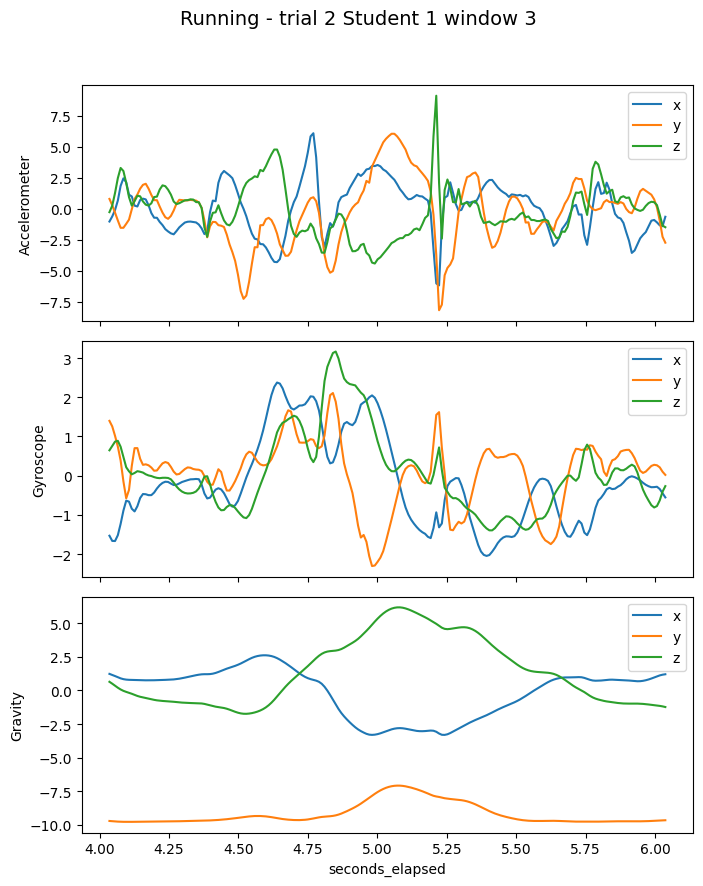

In [282]:
plot_window(win["Stairs"]["2"]["Student1"][1], activity_name="Running - trial 2 Student 1 window 3")


In [273]:
# Load the index file created by save_windows
idx = pd.read_csv("windows/index.csv")

# Count windows per activity
counts = idx.groupby("activity")["window_idx"].count().reset_index(name="num_windows")

print(counts)

  activity  num_windows
0  Running            9
1      Sit           10
2   Stairs           12
3    Stand           10
4  Walking           21
